# Embeddings Tutorial

This notebook picks apart various properties of tokenization and using a model to embed some text.   It can be used to understand the inner workings a little better.

In [1]:
# Import Packages
import pandas as pd
import seaborn as sns

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
sentences = [
    "I went down to the bakery for a pie.",   # 0
    "I went to Paris for a croissant.",       # 1
    "I went to paris for a croissant.",       # 2
    "I went to CDG for a croissant.",         # 3 (CDG: Charles de Gaulle airport in Paris)
    "Should I eat one more bite?",            # 4
    "I went to France for a croissant.",      # 5
    "I went to Paris for 100 croissants.",    # 6
    "I went to Paris for 10000 croissants.",  # 7
    "I went to Paris for 1000000 croissants." # 8
]

## Tokenization

Large Language models use a different style of tokenization than what we have seen so far.  It is used when the words get long or complicated.  These newer tokenizers break words into what are called word parts.  

This ensures that the 'dictionary' of words the model understands does not grow exponentially AND ensures that new words that the model has not seen before can be properly handled.

- ex. 'croissants' gets broken into 3 separate word parts - 'cro', 'iss', 'ants' (seen below)


For this lecture, we are focusing on an older style of tokenizer that chooses to tokenize a word based on there being white space before and after it.

In [3]:
def tokenize_sentence(tokenizer, index):
    print("         Loading sentence...")
    # Print the original sentence.
    print(' Original: ', sentences[index])
    # Print the sentence split into tokens.
    print('Tokenized: ', tokenizer.tokenize(sentences[index]))
    # Print the sentence mapped to token ids.
    print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[index])))

# Load the RoBERTa tokenizer.
print('         Loading RoBERTa tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('roberta-base', do_lower_case=True)

         Loading RoBERTa tokenizer...


## Tokenization: case sensitivity

In [4]:
sentence_1_index = 1
sentence_2_index = 2

tokenize_sentence(tokenizer, sentence_1_index)
tokenize_sentence(tokenizer, sentence_2_index)

         Loading sentence...
 Original:  I went to Paris for a croissant.
Tokenized:  ['I', 'Ġwent', 'Ġto', 'ĠParis', 'Ġfor', 'Ġa', 'Ġcro', 'iss', 'ant', '.']
Token IDs:  [100, 439, 7, 2201, 13, 10, 11398, 3006, 927, 4]
         Loading sentence...
 Original:  I went to paris for a croissant.
Tokenized:  ['I', 'Ġwent', 'Ġto', 'Ġpar', 'is', 'Ġfor', 'Ġa', 'Ġcro', 'iss', 'ant', '.']
Token IDs:  [100, 439, 7, 2242, 354, 13, 10, 11398, 3006, 927, 4]


Take a look at how the word "Paris" is broken into word parts given its uppercase P in sentence[1] and lowercase p in sentence[2]

The word is broken into 2 word parts with paris vs 1 word part with Paris.  The defined vocabulary for the tokenizer is aware of the latter, but has to break down the former to derive meaning from the word.

This has implications on proper nouns (which should be capitalized) and informal text such as tweets where case is traditionally disregarded.

## Tokenization: Numbers

In [5]:
sentence_1_index = 6
sentence_2_index = 8

tokenize_sentence(tokenizer, sentence_1_index)
tokenize_sentence(tokenizer, sentence_2_index)

         Loading sentence...
 Original:  I went to Paris for 100 croissants.
Tokenized:  ['I', 'Ġwent', 'Ġto', 'ĠParis', 'Ġfor', 'Ġ100', 'Ġcro', 'iss', 'ants', '.']
Token IDs:  [100, 439, 7, 2201, 13, 727, 11398, 3006, 3277, 4]
         Loading sentence...
 Original:  I went to Paris for 1000000 croissants.
Tokenized:  ['I', 'Ġwent', 'Ġto', 'ĠParis', 'Ġfor', 'Ġ100', '0000', 'Ġcro', 'iss', 'ants', '.']
Token IDs:  [100, 439, 7, 2201, 13, 727, 14200, 11398, 3006, 3277, 4]


Here we are trying to understand if the model can derive meaning from numbers.

## Tokenization: Acronyms

In [6]:
sentence_1_index = 3

tokenize_sentence(tokenizer, sentence_1_index)

         Loading sentence...
 Original:  I went to CDG for a croissant.
Tokenized:  ['I', 'Ġwent', 'Ġto', 'ĠCD', 'G', 'Ġfor', 'Ġa', 'Ġcro', 'iss', 'ant', '.']
Token IDs:  [100, 439, 7, 7522, 534, 13, 10, 11398, 3006, 927, 4]


# Testing out tokenizing on acronyms

# Embedding Similarity

In [7]:
# Load SentenceBERT model from Hugging Face website
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate embeddings from text
embeddings = model.encode(sentences)

# Calculate cosine similarity across the corpus
similarity_scores = cosine_similarity(embeddings)

## Visualize Similarity Results

Sentences:
sentence[0]: I went down to the bakery for a pie.
sentence[1]: I went to Paris for a croissant.
sentence[2]: I went to paris for a croissant.
sentence[3]: I went to CDG for a croissant.
sentence[4]: Should I eat one more bite?
sentence[5]: I went to France for a croissant.
sentence[6]: I went to Paris for 100 croissants.
sentence[7]: I went to Paris for 10000 croissants.
sentence[8]: I went to Paris for 1000000 croissants.

Similarity Scores:


<Axes: >

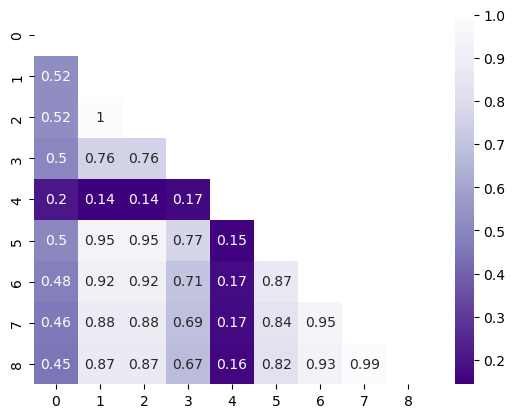

In [8]:
# Show sentences
print("Sentences:")
for i in range(0,len(sentences)):
    print(f"sentence[{i}]: {sentences[i]}")

# Add some space
print("")
print("Similarity Scores:")
# Show sentence similarities
import numpy as np
matrix = np.triu(similarity_scores)
sns.heatmap(similarity_scores, cmap="Purples_r",annot=True, mask=matrix)

### Results from Embedding Similarity
Purposefully have lots of overlap across sentences.  

- Take a look at --> <b>sentences[2] and sentences[3]</b>.  The only difference is how the city Paris is handled.  Their similarity is ranked at 100% even though paris is broken into two word parts vs one word part.

- Given that <b>sentences[2] and sentences[3]</b> are 100% similar, consider their columns  (they are identical).  [Conclude] The relationship of similarity is bi-directional.  
